In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 70


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

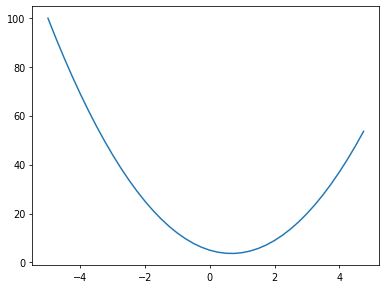

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

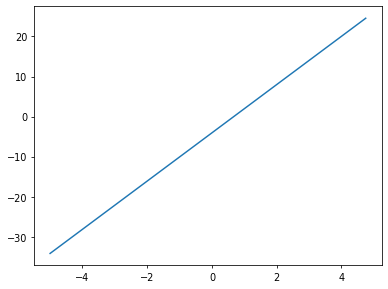

In [5]:
derivative = lambda x: 6*x - 4
derivative_ys = derivative(xs)
plt.plot(xs, derivative_ys)

In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: 'Value') -> 'Value':
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other: 'Value') -> 'Value':
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self) -> 'Value':
        return Value((math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1), (self, ), 'tanh')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = f * d; L.label = 'L'
L

Value(data=-8.0)

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

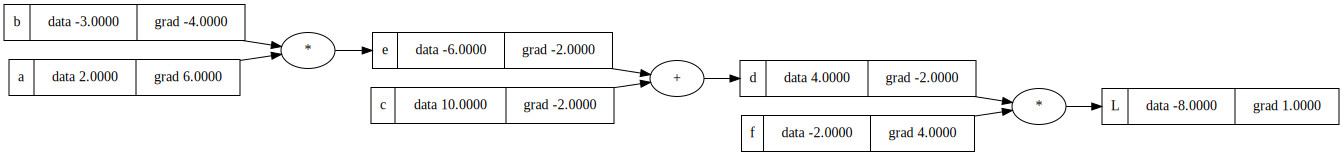

In [8]:
# manual ackpropagation using chain rule

# dL/dL
L.grad = 1.0

# dL/dd = f
d.grad = f.data

# dL/df = d
f.grad = d.data

# dL/dc = (dd/dc) * (dL/dd)
c.grad = 1.0 * d.grad

# dL/de = (dd/de) * (dL/dd)
e.grad = 1.0 * d.grad

# dL/da = (de/da) * (dL/de)
a.grad = b.data * e.grad

# dL/db = (de/db) * (dL/de)
b.grad = a.data * e.grad

draw_dot(L)

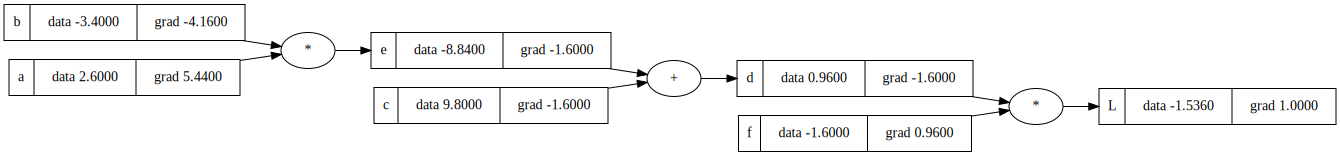

In [9]:
# input "neurons"
a.data += 0.1 * a.grad # little step in the gradient vector direction
b.data += 0.1 * b.grad # gradient ascend, essentially
c.data += 0.1 * c.grad
f.data += 0.1 * f.grad

# feed forward step
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = f * d; L.label = 'L'

# pretend this was done by backpropagation
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = 1.0 * d.grad
e.grad = 1.0 * d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad

draw_dot(L)

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# weighter sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# squishification function
o = n.tanh(); o.label = 'o'

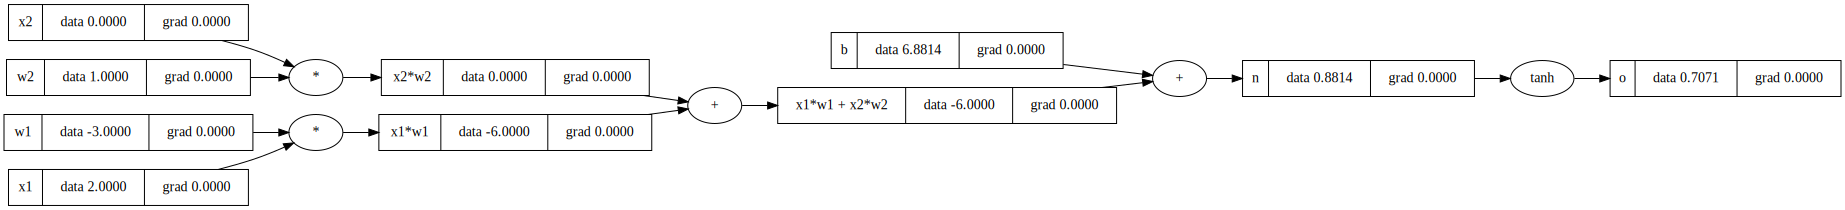

In [11]:
draw_dot(o)

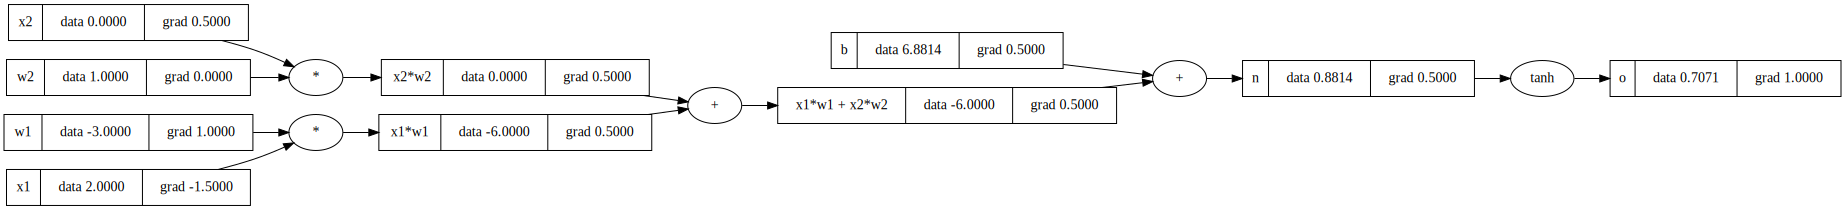

In [12]:
# do/do
o.grad = 1.0

# do/dn = (tanh(n))' = 1 - tanh^2(n) = 1 - o^2
n.grad = 0.5

# addition operation just propagates the gradient
x1w1x2w2.grad = 0.5
b.grad = 0.5

# addition operation just propagates the gradient
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

In [13]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: 'Value') -> 'Value':
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # according to chain rule, addition operation just propagates the gradient
            # so as seen previously, the gradient is localGrad*globalGrad = 1.0 * globalGrad
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other: 'Value') -> 'Value':
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self) -> 'Value':
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self->(tanh)->out > ...
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

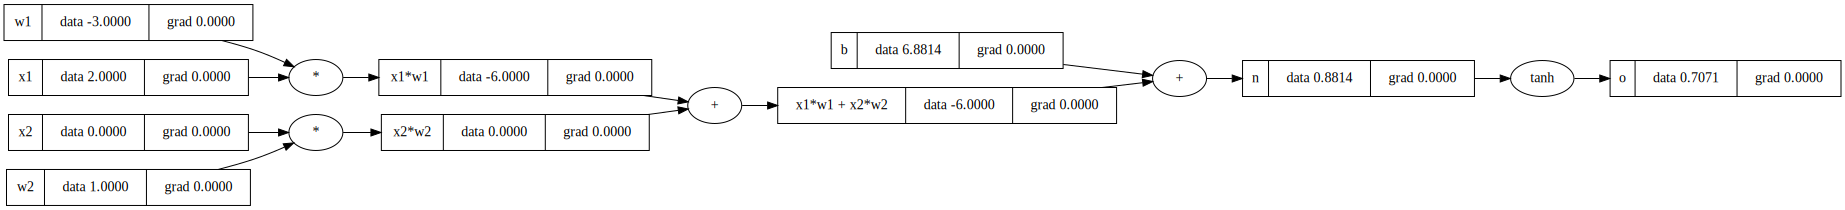

In [14]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: 'Value') -> 'Value':
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # according to chain rule, addition operation just propagates the gradient
            # so as seen previously, the gradient is localGrad*globalGrad = 1.0 * globalGrad
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other: 'Value') -> 'Value':
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self) -> 'Value':
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self->(tanh)->out > ...
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    # public backward function for initiating the backpropagation
    def backward(self):
        # topologicaly sort all the nodes,
        # so that all the dependencies are known before the gradient computation
        topological_order = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topological_order.append(v)
        build_topo(self)

        self.grad = 1.0 # base case, because otherwise the chain rule would involve multiplication by 0

        # iterate in reverse topological order 
        # and call the function to propagate the gradient computation
        for node in reversed(topological_order):
            node._backward()

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# weighter sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# squishification function
o = n.tanh(); o.label = 'o'

draw_dot(o)

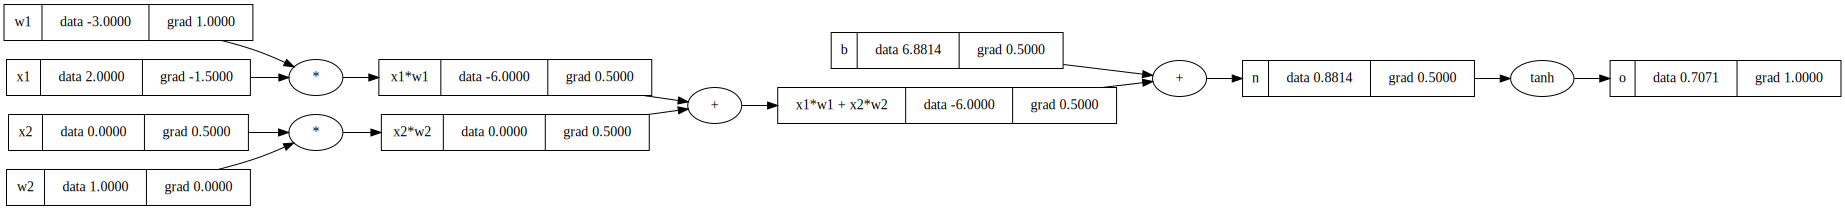

In [15]:
o.backward()
draw_dot(o)

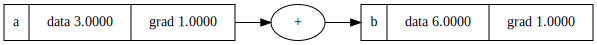

In [16]:
# but there is an issue with repetitive usage of variables,
# since the gradient is assigned, not incremented
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [17]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: 'Value') -> 'Value':
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # according to chain rule, addition operation just propagates the gradient
            # so as seen previously, the gradient is localGrad*globalGrad = 1.0 * globalGrad
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other: 'Value') -> 'Value':
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self  \
            #              > out > ...
            # ... > other /
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self) -> 'Value':
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # according to chain rule, d(out)/d(self) * dL/d(out)
            # ... > self->(tanh)->out > ...
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    # public backward function for initiating the backpropagation
    def backward(self):
        # topologicaly sort all the nodes,
        # so that all the dependencies are known before the gradient computation
        topological_order = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topological_order.append(v)
        build_topo(self)

        self.grad = 1.0 # base case, because otherwise the chain rule would involve multiplication by 0

        # iterate in reverse topological order 
        # and call the function to propagate the gradient computation
        for node in reversed(topological_order):
            node._backward()

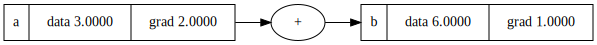

In [18]:
# now that the gradients are incremented, the bug is fixed
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

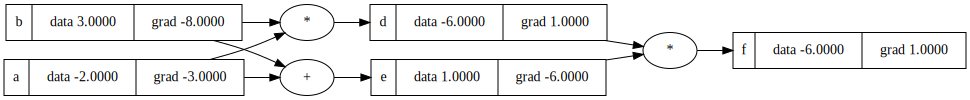

In [19]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)